**Global Forecasting Models: Dependent multi-series forecasting**

**Without regressors**

In [36]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries

In [37]:
# Data download
# ==============================================================================
url = (
       'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
       'data/guangyuan_air_pollution.csv'
)
data = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()
data = data[['CO', 'SO2', 'PM2.5']]
data.head()

,CO,SO2,PM2.5
date,,,
2013-03-01,9600.0,204.0,181.0
2013-03-02,20198.0,674.0,633.0
2013-03-03,47195.0,1661.0,1956.0
2013-03-04,15000.0,485.0,438.0
2013-03-05,59594.0,2001.0,3388.0


In [38]:
# Split data into train-val-test
# ==============================================================================
end_train = '2017-01-01 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}"
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}"
    f"(n={len(data_test)})"
)

Train dates : 2013-03-01 00:00:00 --- 2017-01-01 00:00:00(n=1403)
Test dates  : 2017-01-02 00:00:00 --- 2017-02-28 00:00:00(n=58)


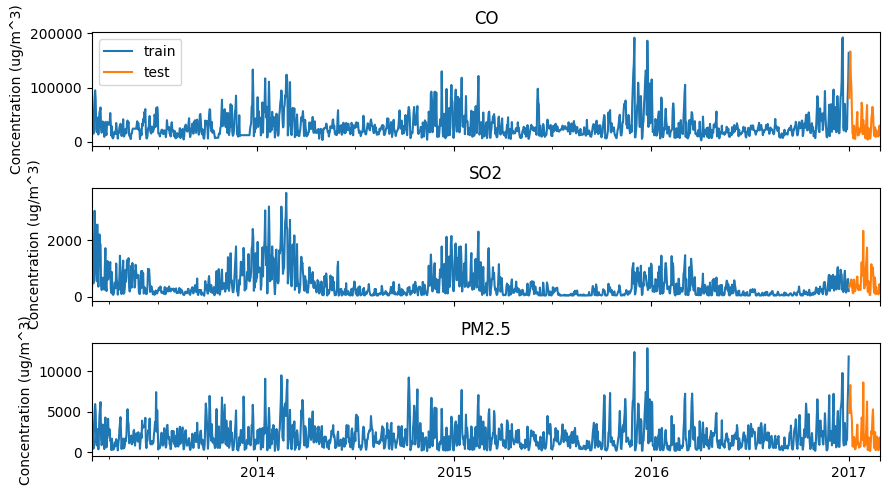

In [39]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 5), sharex=True)

data_train['CO'].plot(label='train', ax=axes[0])
data_test['CO'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Concentration (ug/m^3)')
axes[0].set_title('CO')
axes[0].legend()

data_train['SO2'].plot(label='train', ax=axes[1])
data_test['SO2'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('Concentration (ug/m^3)')
axes[1].set_title('SO2')

data_train['PM2.5'].plot(label='train', ax=axes[2])
data_test['PM2.5'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('Concentration (ug/m^3)')
axes[2].set_title('PM2.5')

fig.tight_layout()
plt.show();

In [44]:
# Create and fit forecaster MultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'CO',
                 lags               = 3,
                 steps              = 3,
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 n_jobs             = 'auto'
             )

forecaster.fit(series=data_train)
forecaster

ForecasterAutoregMultiVariate 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [1 2 3] 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Window size: 3 
Target series, level: CO 
Multivariate series (names): ['CO', 'SO2', 'PM2.5'] 
Maximum steps predicted: 3 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Crea

In [42]:
# Extract training matrix
# ==============================================================================
X, y = forecaster.create_train_X_y(series=data_train)

# # X and y to train model for step 1
# X_1, y_1 = forecaster.filter_train_X_y_for_step(
#                step    = 1,
#                X_train = X,
#                y_train = y,
#            )

# X_1
X

,CO_lag_1,CO_lag_2,CO_lag_3,SO2_lag_1,SO2_lag_2,SO2_lag_3,PM2.5_lag_1,PM2.5_lag_2,PM2.5_lag_3
date,,,,,,,,,
2013-03-06,47195.0,20198.0,9600.0,1661.0,674.0,204.0,1956.0,633.0,181.0
2013-03-07,15000.0,47195.0,20198.0,485.0,1661.0,674.0,438.0,1956.0,633.0
2013-03-08,59594.0,15000.0,47195.0,2001.0,485.0,1661.0,3388.0,438.0,1956.0
2013-03-09,81291.0,59594.0,15000.0,3052.0,2001.0,485.0,4934.0,3388.0,438.0
2013-03-10,94792.0,81291.0,59594.0,2369.0,3052.0,2001.0,5952.0,4934.0,3388.0
...,...,...,...,...,...,...,...,...,...
2016-12-28,69800.0,68300.0,20500.0,926.0,770.0,242.0,3603.0,2991.0,829.0
2016-12-29,22700.0,69800.0,68300.0,365.0,926.0,770.0,1107.0,3603.0,2991.0
2016-12-30,18500.0,22700.0,69800.0,151.0,365.0,926.0,925.0,1107.0,3603.0


In [41]:
# Predict with forecaster MultiVariate
# ==============================================================================
# Predict as many steps as defined in the forecaster initialization
predictions = forecaster.predict()
display(predictions)

,CO
2017-01-02,66750.674592
2017-01-03,54232.586125
2017-01-04,66716.425009


In [26]:
data_train.tail()

,CO,SO2,PM2.5
date,,,
2016-12-28,25400.0,200.0,1685.0
2016-12-29,23500.0,390.0,1546.0
2016-12-30,78500.0,627.0,5866.0
2016-12-31,107600.0,634.0,8107.0
2017-01-01,164000.0,205.0,11844.0


In [25]:
# Create input matrix for predict method
# ==============================================================================
X_predict = forecaster.create_predict_X(steps=3)
X_predict

,CO_lag_1,CO_lag_2,CO_lag_3,SO2_lag_1,SO2_lag_2,SO2_lag_3,PM2.5_lag_1,PM2.5_lag_2,PM2.5_lag_3
2017-01-02,164000.0,107600.0,78500.0,205.0,634.0,627.0,11844.0,8107.0,5866.0
2017-01-03,164000.0,107600.0,78500.0,205.0,634.0,627.0,11844.0,8107.0,5866.0
2017-01-04,164000.0,107600.0,78500.0,205.0,634.0,627.0,11844.0,8107.0,5866.0
